# MobileNetV3 YOLOv3 for Text Detection

A text detection model based on MobileNetV3 and YOLOv3.<br>
Pruned and quantized for deployment on edge devices.

- [x] Pretrained MobileNetV2 backbone
- [x] YOLOv3 top end
- [x] Basic Pruning, Quantization integration
- [x] Training pipeline (for ICDAR 2015)
- [x] Switch backbone to MobileNetV3
- [x] Mixed Precision Training
- [x] Advanced Pruning and quantization

- [ ] Basic Inference
- [ ] Performance Evaluation
- [ ] Deflate Jupyter Notebook into file structure
- [ ] Advanced training pipeline (COCO-Text dataset, batch augmentation, etc.)
- [ ] Live Image-Feed Inference

In [1]:
import os
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.init as init
import torchvision.ops as ops
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn.utils.prune as prune
import torch.quantization.quantize_fx as quantize_fx

from PIL import Image, ImageDraw
from pathlib import Path
from torch.nn import functional as F
from torchvision import transforms
from torch.cuda.amp import autocast
from torch.quantization import quantize_dynamic
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

%matplotlib inline

In [2]:
torch.manual_seed(42);
torch.cuda.manual_seed_all(42);

---

## Model Definition

In [3]:
class MobileYOLOv3(nn.Module):
    def __init__(self, num_classes):
        super(MobileYOLOv3, self).__init__()
        self.num_classes = num_classes
        self.mobilenet = models.mobilenet_v3_small(weights='IMAGENET1K_V1').features
        self.conv1 = nn.Conv2d(576, 5 * (num_classes + 5), kernel_size=1)
        self._init_weights()
        
    def _init_weights(self):
        init.kaiming_uniform_(self.conv1.weight,  mode='fan_in', nonlinearity='leaky_relu')
        
    def forward(self, x):
        x = self.mobilenet(x)
        x = self.conv1(x)
        return x  # [batch_size, 5*(num_classes+5), grid_h, grid_w]

---

## Loss Definition

In [4]:
class YoLoss(nn.Module):
    def __init__(self, num_classes, lambda_obj=1, lambda_noobj=10, lambda_class=1, lambda_bbox=1):
        super(YoLoss, self).__init__()
        self.num_classes = num_classes
        self.lambda_obj = lambda_obj
        self.lambda_noobj = lambda_noobj
        self.lambda_class = lambda_class
        self.lambda_bbox = lambda_bbox
        self.mse_loss = nn.MSELoss(reduction='sum')
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='sum')

    def forward(self, predictions, targets):
        # Reshape predictions
        batch_size, _, grid_h, grid_w = predictions.shape
        predictions = predictions.view(batch_size, 5, self.num_classes + 5, grid_h, grid_w)
        predictions = predictions.permute(0, 1, 3, 4, 2).contiguous()
        
        # Reshape targets (assuming targets are already in the correct shape)
        targets = targets.view(batch_size, 5, grid_h, grid_w, -1)

        obj_pred = predictions[..., 4:5]
        class_pred = predictions[..., 5:]
        bbox_pred = predictions[..., :4]

        obj_target = targets[..., 4:5]
        class_target = targets[..., 5:]
        bbox_target = targets[..., :4]

        # Create object mask
        obj_mask = obj_target.bool()  # Shape: [batch_size, 5, grid_h, grid_w, 1]
        obj_mask_expanded = obj_mask.expand(-1, -1, -1, -1, 4)  # Shape: [batch_size, 5, grid_h, grid_w, 4]

        # Object loss
        obj_loss = self.bce_loss(obj_pred[obj_mask], obj_target[obj_mask])
        
        # No object loss
        noobj_mask = ~obj_mask
        noobj_loss = self.bce_loss(obj_pred[noobj_mask], obj_target[noobj_mask])
        
        # Class loss
        class_loss = self.bce_loss(class_pred[obj_mask.squeeze(-1)], class_target[obj_mask.squeeze(-1)]) if obj_mask.any() else torch.tensor(0.0).to(predictions.device)
        
        # Bounding box loss
        bbox_loss = self.mse_loss(bbox_pred[obj_mask_expanded], bbox_target[obj_mask_expanded]) if obj_mask.any() else torch.tensor(0.0).to(predictions.device)

        total_loss = (
            self.lambda_obj * obj_loss +
            self.lambda_noobj * noobj_loss +
            self.lambda_class * class_loss +
            self.lambda_bbox * bbox_loss
        )

        return total_loss / batch_size
    
def test_loss(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for data, targets in test_loader:
            data = data.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            outputs = model(data)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    
    return test_loss / len(test_loader)

---

## Training

In [5]:
class ICDAR2015(Dataset):
    def __init__(self, image_dir, label_dir, input_size=(256, 448)):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.input_size = input_size
        self.grid_size = (input_size[0] // 32, input_size[1] // 32)  # 8x14 for input size 256x448
        self.num_classes = 1  # Assuming 1 class only, can be adjusted
        self.transform = transforms.Compose([
            transforms.Resize(input_size),
            transforms.ToTensor()
        ])
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        original_size = image.size  # original width, height
        image = self.transform(image)

        txt_name = 'gt_' + os.path.splitext(img_name)[0] + '.txt'
        txt_path = os.path.join(self.label_dir, txt_name)

        boxes = []
        try:
            with open(txt_path, 'r', encoding='utf-8-sig') as f:
                lines = f.read().strip().split('\n')

            for line in lines:
                parts = line.split(',')
                if len(parts) < 8:
                    continue
                try:
                    # Load box coordinates
                    x1, y1, x2, y2, x3, y3, x4, y4 = map(float, parts[:8])
                    x_center = (x1 + x3) / 2
                    y_center = (y1 + y3) / 2
                    width = x3 - x1
                    height = y3 - y1

                    # Normalize coordinates
                    x_center /= original_size[0]
                    y_center /= original_size[1]
                    width /= original_size[0]
                    height /= original_size[1]

                    boxes.append([x_center, y_center, width, height])  # Store in YOLO format
                except ValueError:
                    print(f"Skipping invalid box in {txt_name}: {parts[:8]}")
        except Exception as e:
            print(f"Error reading {txt_name}: {str(e)}")
            boxes = [[0.5, 0.5, 1, 1]]  # Fallback if error occurs

        boxes = torch.tensor(boxes, dtype=torch.float32)

        # Create target tensor with shape [8, 14, 5, 6]
        target = torch.zeros((*self.grid_size, 5, self.num_classes + 5), dtype=torch.float32)

        for box in boxes:
            i = int(box[1] * self.grid_size[0])  # y grid index
            j = int(box[0] * self.grid_size[1])  # x grid index

            # Calculate cell coordinates (cx, cy)
            x_cell = box[0] * self.grid_size[1] - j
            y_cell = box[1] * self.grid_size[0] - i
            w_cell = box[2]  # width (normalized)
            h_cell = box[3]  # height (normalized)

            # Loop through the 5 anchor boxes
            for anchor in range(5):
                if target[i, j, anchor, 4] == 0:  # If no object assigned yet to this anchor
                    target[i, j, anchor, :4] = torch.tensor([x_cell, y_cell, w_cell, h_cell])
                    target[i, j, anchor, 4] = 1  # Objectness score
                    target[i, j, anchor, 5] = 1  # Class score (assuming 1 class, adjust as needed)
                    break  # Assign to the first available anchor and move on

        return image, target

---

## Pruning & Quantization Definition

In [6]:
def prune_model(model, amount=0.7):
    for _, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0)
            prune.remove(module, 'weight')
            if module.bias is not None:
                prune.l1_unstructured(module, name='bias', amount=amount/2)
                prune.remove(module, 'bias')
    parameters_to_prune = [(module, 'weight') for module in model.modules() if isinstance(module, (nn.Conv2d, nn.Linear))]
    prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=amount/2)
    return model

def quantize_model(model, device):
    model = model.cpu()  # Ensure the model is on the CPU as quantization happens on CPU
    quantized_model = torch.quantization.quantize_dynamic(
        model, {nn.Conv2d, nn.Linear}, dtype=torch.qint8, inplace=True  # Use inplace=True against deepcopy
    )
    return quantized_model.to(device)

---

## Training

In [7]:
batch_size = 32
num_workers = 4
num_classes = 1
learning_rate = 1e-3
num_epochs = 25
target_architecture = 'cuda' # else 'cpu'

# https://www.kaggle.com/datasets/bestofbests9/icdar2015
dataset_path = Path('/kaggle/input/icdar2015')
train_path = dataset_path / 'ch4_training_images'
train_labels = dataset_path / 'ch4_training_localization_transcription_gt'
test_path = dataset_path / 'ch4_test_images'
test_labels = dataset_path / 'ch4_test_localization_transcription_gt'

model_path = 'pq_yolov3_mobilenetv3.pth'

train_dataset = ICDAR2015(train_path, train_labels)
test_dataset = ICDAR2015(test_path, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using training device: {device}")

Using training device: cuda


In [8]:
model = MobileYOLOv3(num_classes=num_classes).to(device)
criterion = YoLoss(num_classes=num_classes)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=2e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
scaler = torch.amp.GradScaler(str(device))

lossi = []
losst = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for batch_idx, (data, targets) in enumerate(train_loader):        
        data = data.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type=str(device)):
            outputs = model(data)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        
    epoch_loss = epoch_loss / len(train_loader)
    lossi.append(epoch_loss)
    
    t_loss = test_loss(model, test_loader, criterion, device)
    losst.append(t_loss)

    scheduler.step(epoch_loss)

    # Print training and test loss
    print(f'Epoch [{epoch+1:3}/{num_epochs}] | Train Loss: {epoch_loss:8.3f} | Test Loss: {t_loss:8.3f} | LR: {optimizer.param_groups[0]["lr"]:.6f}')

Epoch [  1/25] | Train Loss: 3064.755 | Test Loss:  190.656 | LR: 0.001000
Epoch [  2/25] | Train Loss:  134.392 | Test Loss:  123.829 | LR: 0.001000
Epoch [  3/25] | Train Loss:   97.302 | Test Loss:  103.804 | LR: 0.001000
Epoch [  4/25] | Train Loss:   89.804 | Test Loss:   92.817 | LR: 0.001000
Epoch [  5/25] | Train Loss:   86.696 | Test Loss:   86.746 | LR: 0.001000
Epoch [  6/25] | Train Loss:   84.909 | Test Loss:   83.331 | LR: 0.001000
Epoch [  7/25] | Train Loss:   82.898 | Test Loss:   81.418 | LR: 0.001000
Epoch [  8/25] | Train Loss:   82.089 | Test Loss:   79.315 | LR: 0.001000
Epoch [  9/25] | Train Loss:   80.198 | Test Loss:   78.546 | LR: 0.001000
Epoch [ 10/25] | Train Loss:   79.298 | Test Loss:   77.443 | LR: 0.001000
Epoch [ 11/25] | Train Loss:   79.603 | Test Loss:   77.314 | LR: 0.001000
Epoch [ 12/25] | Train Loss:   78.532 | Test Loss:   76.473 | LR: 0.001000
Epoch [ 13/25] | Train Loss:   78.291 | Test Loss:   77.193 | LR: 0.001000
Epoch [ 14/25] | Train Lo

In [9]:
# Prune, Quantize
pruned_model = prune_model(model)
quantized_model = quantize_model(pruned_model, device)

# Save the quantized model
torch.save(quantized_model.state_dict(), model_path)

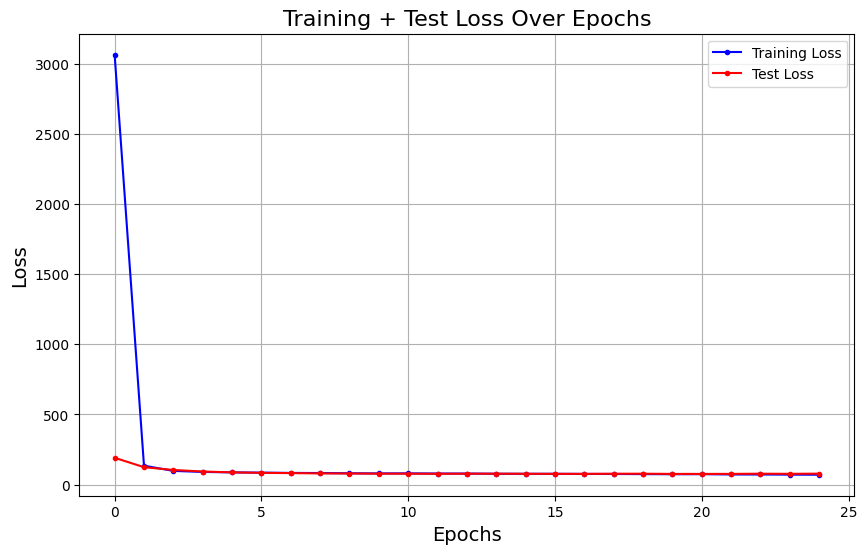

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), lossi, label="Training Loss", color='blue', marker='o', linestyle='-', markersize=3)
plt.plot(range(num_epochs), losst, label="Test Loss", color="red", marker='o', linestyle='-', markersize=3)

plt.title('Training + Test Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.legend(loc='upper right')

plt.show();

In [11]:
def load_model(model_class, num_classes, model_path, target_device='cpu'):
    """
    Load a PyTorch model for inference on the target device, regardless of where it was originally trained.
    """
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"No file at {model_path}")

    if isinstance(target_device, str):
        target_device = torch.device(target_device)

    # Load the state dict to CPU first
    state_dict = torch.load(model_path, map_location=target_device, weights_only=False)
    
    # If it's a full checkpoint, extract just the model state dict
    if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
        state_dict = state_dict['model_state_dict']

    # Remove pruning-related keys
    new_state_dict = {}
    for key, value in state_dict.items():
        if 'weight_mask' not in key:
            new_key = key.replace('weight_orig', 'weight')
            new_state_dict[new_key] = value
        
    model = model_class(num_classes)
    model.load_state_dict(new_state_dict)
    model = model.to(target_device)
    model.eval()
    return model

In [12]:
def yolo_to_icdar2015(predictions, original_sizes, conf_threshold=0.5, grid_size=(8, 14), input_size=(256, 448)):
    batch_size, _, grid_h, grid_w = predictions.shape
    predictions = predictions.view(batch_size, 5, -1, grid_h, grid_w).permute(0, 1, 3, 4, 2).contiguous()

    input_w, input_h = input_size  # Resized width and height
    bboxes_per_image = []

    for img_idx in range(batch_size):
        boxes = []
        orig_w, orig_h = original_sizes[img_idx]  # Get the original size of the current image

        # Calculate the scaling factors between the resized input and the original image size
        scale_w, scale_h = orig_w / input_w, orig_h / input_h

        for i in range(5):  # Iterate over the 5 anchor boxes
            for y in range(grid_h):
                for x in range(grid_w):
                    pred = predictions[img_idx, i, y, x]
                    obj_conf = pred[4].sigmoid()  # Objectness confidence
                    if obj_conf > conf_threshold:
                        # Extract bounding box (cx, cy, w, h)
                        cx, cy, w, h = pred[:4].sigmoid()  # Apply sigmoid to bounding box dimensions

                        # Convert relative to absolute pixel coordinates (in the resized image's grid space)
                        cx_abs = (x + cx) * (input_w / grid_w)  # Center x relative to the resized image
                        cy_abs = (y + cy) * (input_h / grid_h)  # Center y relative to the resized image
                        w_abs = w * input_w  # Width relative to the resized image
                        h_abs = h * input_h  # Height relative to the resized image

                        # Calculate corner coordinates from (cx, cy, w, h) in the resized image space
                        x_min = cx_abs - w_abs / 2
                        y_min = cy_abs - h_abs / 2
                        x_max = cx_abs + w_abs / 2
                        y_max = cy_abs + h_abs / 2

                        # Scale the coordinates back to the original image size
                        x_min *= scale_w
                        x_max *= scale_w
                        y_min *= scale_h
                        y_max *= scale_h

                        # Convert to four-point bounding box (assuming upright box for simplicity)
                        box = [
                            x_min, y_min,  # Top-left corner
                            x_max, y_min,  # Top-right corner
                            x_max, y_max,  # Bottom-right corner
                            x_min, y_max   # Bottom-left corner
                        ]
                        boxes.append(box)
        
        bboxes_per_image.append(boxes)
    return bboxes_per_image

In [13]:
def process_batch(model, dataset, device, num_images=10, conf_threshold=0.5):
    model.eval()
    sampled_indices = random.sample(range(len(dataset)), num_images)
    
    original_images = []
    original_sizes = []  # List to hold original sizes
    transformed_images = []

    for idx in sampled_indices:
        image, _ = dataset[idx]
        original_size = (image.shape[2], image.shape[1])  # (width, height)

        original_images.append(image)
        original_sizes.append(original_size)  # Append original size
        transformed_images.append(image.unsqueeze(0))  # Add batch dimension

    transformed_images = torch.cat(transformed_images).to(device)

    with torch.no_grad():
        predictions = model(transformed_images)

    return yolo_to_icdar2015(predictions, original_sizes, conf_threshold), original_images

In [14]:
def visualize_predictions(model, dataset, device, num_images=10, conf_threshold=0.5):
    predicted_boxes, original_images = process_batch(model, dataset, device, num_images, conf_threshold)

    for img_idx in range(num_images):
        img = original_images[img_idx]
        img_disp = img.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format for display

        fig, ax = plt.subplots(1)
        ax.imshow(img_disp)
        boxes = predicted_boxes[img_idx]
        
        for box in boxes:
            x1, y1, x2, y2, x3, y3, x4, y4 = box
            rect = patches.Rectangle((x1, y1), x3 - x1, y3 - y1, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
        
        plt.axis('off')  # Hide axes
        plt.show()

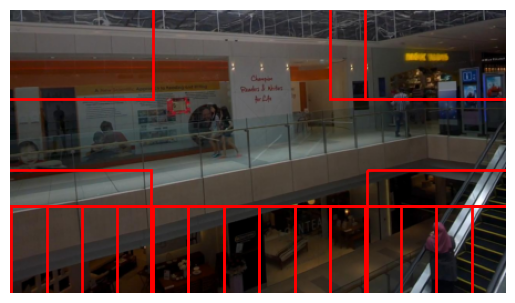

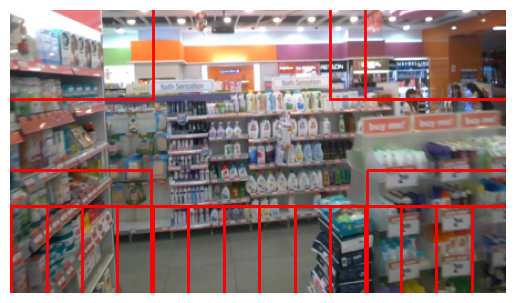

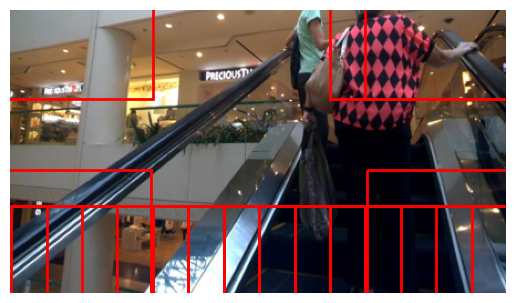

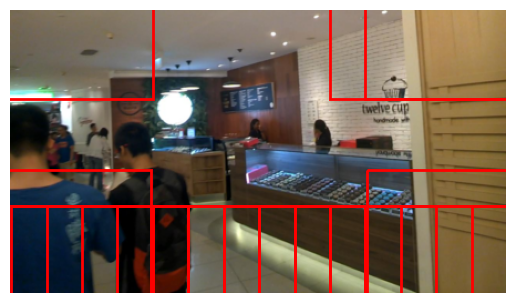

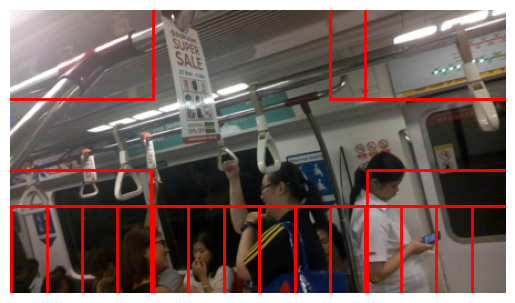

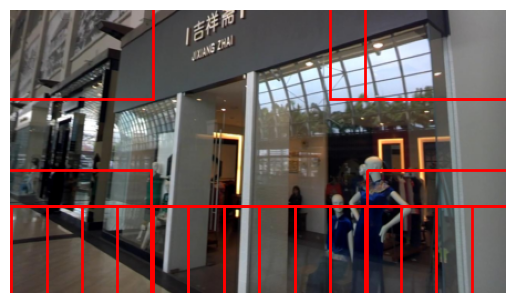

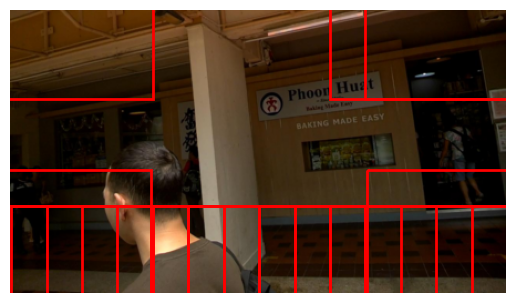

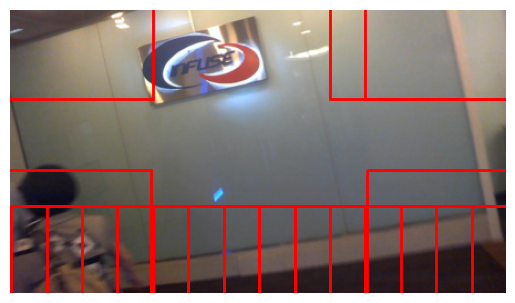

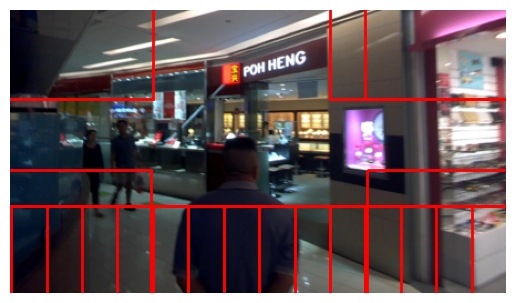

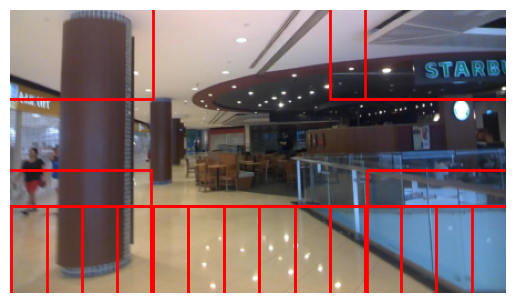

In [24]:
model = load_model(MobileYOLOv3, num_classes, model_path, 'cpu')
dataset = ICDAR2015(train_path, train_labels)
visualize_predictions(model, dataset, 'cpu', num_images=10, conf_threshold=0.973) # Still horrible